In [19]:
'''
Build simple text classification model using a logistic classifier to determine sentiment of 
reviews on baby products and to help identify positive and negative review similarities, and
probability of positive given the review text
'''

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from collections import Counter

from sklearn import linear_model
from sklearn.cross_validation import train_test_split

# Grab data and and preview
products = pd.read_csv(r'../data/amazon_baby.csv')

products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [2]:
print('Total number of reviews:', len(products))

Total number of reviews: 183531


In [3]:
# Find average rating of top 10 most reviewd products
cols = ['name', 'rating']

avg_review = products[cols].groupby('name').agg({'rating': [np.size, np.mean]})
top_avg_review = avg_review.sort_values([('rating','size')], ascending= False)[:10]
top_avg_review

rating          
                                                     size      mean
name                                                               
Vulli Sophie the Giraffe Teether                      785  4.294268
Simple Wishes Hands-Free Breastpump Bra, Pink, ...    562  4.693950
Infant Optics DXR-5 2.4 GHz Digital Video Baby ...    561  3.843137
Baby Einstein Take Along Tunes                        547  4.712980
Cloud b Twilight Constellation Night Light, Turtle    520  4.538462
Fisher-Price Booster Seat, Blue/Green/Gray            489  4.715746
Fisher-Price Rainforest Jumperoo                      450  4.697778
Graco Nautilus 3-in-1 Car Seat, Matrix                419  4.272076
Leachco Snoogle Total Body Pillow                     388  4.414948
Regalo Easy Step Walk Thru Gate, White                374  4.203209

In [4]:
print('Number of products:', len(avg_review))

Number of products: 32417


In [5]:
# Experiment with adding a calculated test column

products['testCol'] = products[('rating')] + 1
products.head()

,name,review,rating,testCol
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,4
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,6
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,6
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,6
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,6


In [6]:
# Remove (drop) test column

products = products.drop('testCol', axis= 1)
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [7]:
# Create function to count occurance of each word in review
def word_count(x):
    '''
    Takes input, x, converts it to a string, and returns dictionary of the count of each word.
    
    input:
    x = 'apples are apples'
    
    output:
    {'apples': 2, 'are': 1}

    '''
    word_string = str(x).split()
    word_count = dict(Counter(word_string))
    return word_count

# Create new column, apply word count function to all reviews, and place output in new column
products['word_count'] = products['review'].apply(word_count)

In [8]:
# Output sample to file
#products.head(100).to_csv(r'../data/products_word_vector.csv')

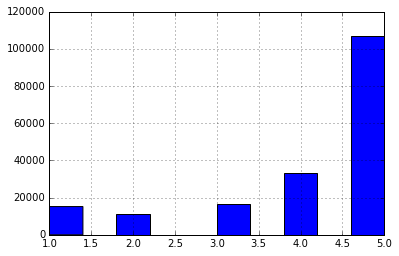

In [9]:
# Show distribution of ratings
products['rating'].hist()

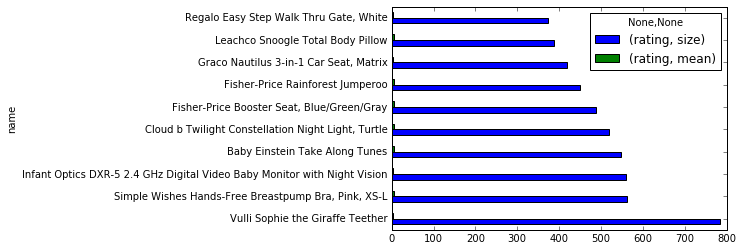

In [10]:
# Show top 10 products by number of reviews
top_avg_review.plot(kind='barh')

In [11]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 
                  'bad', 'terrible', 'awful', 'wow', 'hate']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x169b06780>]], dtype=object)

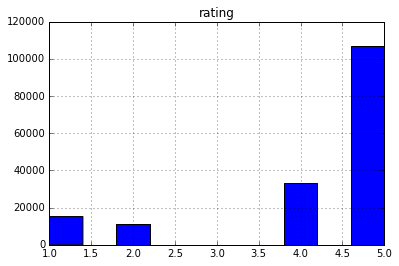

In [12]:
# Remove all 3 star reviews
products = products[products['rating'] != 3]
products.hist()

In [13]:
# Add column to indicate positive (desired) sentiment
products['sentiment'] = products['rating'] >= 4
products.head()

,name,review,rating,word_count,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'love': 1, 'osocozy': 1, 'moist': 1, 'now': 1...",True
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'for': 1, 'comfortable': 1, 'full': 1, 'to': ...",True
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'to': 1, 'like': 1, 'the': 7, 'of': 3, 'What'...",True
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'buy': 1, 'for': 2, 'rock!!': 1, 'going': 1, ...",True
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"{'for': 2, 'to': 6, 'break': 1, 'job': 1, 'pro...",True


In [17]:
# Divide data into training and test sets

train_data, test_data = train_test_split(products, test_size= 0.2, random_state= 0)  #random_state == seed

print('Training n:', len(train_data))
print('Test n:', len(test_data))

Training n: 133401
Test n: 33351


In [20]:
# WORKING: Create and fit model
clf_model = linear_model.LogisticRegression()

In [23]:
clf_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)